,,degrees_east,degrees_north,UTC,millibars,degrees true,knots,knots,meters,seconds,degrees_true,meters,degrees_C,degrees_C,degrees_C,dimensionless,percent,degrees,degrees_true,seconds,

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

# 加载数据
df_Ballycotton = pd.read_csv("./dataProcessed/1训练集5040.csv",encoding = "utf-8",index_col=['time'],parse_dates = ["time"],usecols = ['time','Water_Level'])
# 转化为时间序列
# df_Ballycotton['time'] = pd.to_datetime(df_Ballycotton['time'])
# 设置时间索引
# df_Ballycotton = df_Ballycotton.set_index("time")


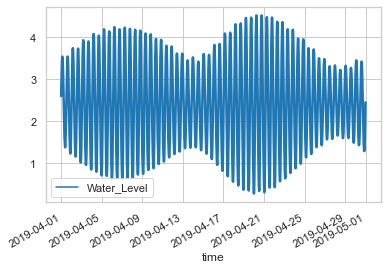

In [38]:
# 画图
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
sns.set_theme(style="whitegrid")
# dataPlot = df_Ballycotton.loc[:,"Water_Level_LAT"]
sns.lineplot(data=df_Ballycotton, palette="tab10", linewidth=2.5,ax=ax)
# 将x轴斜过来显示更好看
fig.autofmt_xdate()

In [40]:
# 数据缺失情况
sum(df_Ballycotton.loc[:,'Water_Level'].isna())

0

In [1]:
import torch
from torch.utils.data import DataLoader

from config import Config

from utils.dataTools import *
from utils.models import lstm_reg,CNNBiLSTM
from utils.trainer import RNNtrain,evaluate,CNNBiLstmtrain

if __name__ == '__main__':
    config = Config()

    print("Data loading...")
    # 序列数据
    dataset = mydataReader("./dataProcessed/testData.csv")

    # 创建X/Y
    # 划分训练集和测试集，70% 作为训练集
    (train_X,train_Y) , (val_X,val_Y) , (test_X,test_Y)= dataset.split(lookback=config.lookback,trainSet_ratio=0.7)

Data loading...


100%|██████████| 19306/19306 [00:00<00:00, 877599.55it/s]

测试集大小为3862


In [3]:
train_Y.shape

(13514, 1)

Data loading...


100%|██████████| 19306/19306 [00:00<00:00, 918409.34it/s]

测试集大小为3862
Model loading...


Training...
torch.Size([30, 10, 1])
Epoch: 0 batch: 0 | loss: 0.019705094397068024
Epoch: 0 batch: 10 | loss: 0.33607885241508484
Epoch: 0 batch: 20 | loss: 0.000769543054047972
Epoch: 0 batch: 30 | loss: 0.2726393938064575
Epoch: 0 batch: 40 | loss: 0.021203193813562393
Epoch: 0 batch: 50 | loss: 0.04818297177553177
Epoch: 0 batch: 60 | loss: 0.17096993327140808
Epoch: 0 batch: 70 | loss: 0.006062351167201996
Epoch: 0 batch: 80 | loss: 0.1910579800605774
Epoch: 0 batch: 90 | loss: 0.030857451260089874
Epoch: 0 batch: 100 | loss: 0.0374203659594059
Epoch: 0 batch: 110 | loss: 0.031342826783657074
Epoch: 0 batch: 120 | loss: 0.029520874843001366
Epoch: 0 batch: 130 | loss: 0.036547791212797165
Epoch: 0 batch: 140 | loss: 0.0184456929564476
Epoch: 0 batch: 150 | loss: 0.022434528917074203
Epoch: 0 batch: 160 | loss: 0.012764845974743366
Epoch: 0 batch: 170 | loss: 0.03900487720966339
Epoch: 0 batch: 180 | loss: 0.01908142678439617
Epoch: 0 batch: 190 | loss: 0.020771780982613564
Epoch: 0

65it [00:01, 67.71it/s]

torch.Size([30, 10, 1])


65it [00:01, 42.90it/s]


Epoch: 0 valLoss: 0.017052776472965925
torch.Size([30, 10, 1])
Epoch: 1 batch: 0 | loss: 0.02305557020008564
Epoch: 1 batch: 10 | loss: 0.0042528631165623665
Epoch: 1 batch: 20 | loss: 0.027642136439681053
Epoch: 1 batch: 30 | loss: 0.008591987192630768
Epoch: 1 batch: 40 | loss: 0.007929915562272072
Epoch: 1 batch: 50 | loss: 0.0031550880521535873
Epoch: 1 batch: 60 | loss: 0.001927277771756053
Epoch: 1 batch: 70 | loss: 0.016833113506436348
Epoch: 1 batch: 80 | loss: 0.008575087413191795
Epoch: 1 batch: 90 | loss: 0.007578182499855757
Epoch: 1 batch: 100 | loss: 0.006434113252907991
Epoch: 1 batch: 110 | loss: 0.006875399965792894
Epoch: 1 batch: 120 | loss: 0.008735651150345802
Epoch: 1 batch: 130 | loss: 0.007489279378205538
Epoch: 1 batch: 140 | loss: 0.005146682728081942
Epoch: 1 batch: 150 | loss: 0.0009930164087563753
Epoch: 1 batch: 160 | loss: 0.0008804653771221638
Epoch: 1 batch: 170 | loss: 0.000559670792426914
Epoch: 1 batch: 180 | loss: 0.0016118125058710575
Epoch: 1 batc

1it [00:01,  1.27s/it]

torch.Size([30, 10, 1])


65it [00:01, 41.84it/s]


Epoch: 1 valLoss: 0.005630116119362585
torch.Size([30, 10, 1])
Epoch: 2 batch: 0 | loss: 0.0038746728096157312
Epoch: 2 batch: 10 | loss: 0.002577702049165964
Epoch: 2 batch: 20 | loss: 0.0023206586483865976
Epoch: 2 batch: 30 | loss: 0.0028464721981436014
Epoch: 2 batch: 40 | loss: 0.0009735760977491736
Epoch: 2 batch: 50 | loss: 0.004179871175438166
Epoch: 2 batch: 60 | loss: 0.0015992297558113933
Epoch: 2 batch: 70 | loss: 0.002554582431912422
Epoch: 2 batch: 80 | loss: 0.005332686007022858
Epoch: 2 batch: 90 | loss: 0.0038338438607752323
Epoch: 2 batch: 100 | loss: 0.008543764241039753
Epoch: 2 batch: 110 | loss: 0.004133793991059065
Epoch: 2 batch: 120 | loss: 0.0072905076667666435
Epoch: 2 batch: 130 | loss: 0.005812487099319696
Epoch: 2 batch: 140 | loss: 0.006989185232669115
Epoch: 2 batch: 150 | loss: 0.0017083237180486321
Epoch: 2 batch: 160 | loss: 0.000982683734036982
Epoch: 2 batch: 170 | loss: 0.00063707260414958
Epoch: 2 batch: 180 | loss: 0.0005501672858372331
Epoch: 2 

46it [00:01, 49.17it/s]

torch.Size([30, 10, 1])


65it [00:01, 43.02it/s]


Epoch: 2 valLoss: 0.004734895733090129
torch.Size([30, 10, 1])
Epoch: 3 batch: 0 | loss: 0.00305557856336236
Epoch: 3 batch: 10 | loss: 0.0022505561355501413
Epoch: 3 batch: 20 | loss: 0.001462903106585145
Epoch: 3 batch: 30 | loss: 0.0021901826839894056
Epoch: 3 batch: 40 | loss: 0.0009649442508816719
Epoch: 3 batch: 50 | loss: 0.003423543181270361
Epoch: 3 batch: 60 | loss: 0.0013209172757342458
Epoch: 3 batch: 70 | loss: 0.0016860582400113344
Epoch: 3 batch: 80 | loss: 0.004085532855242491
Epoch: 3 batch: 90 | loss: 0.0036469832994043827
Epoch: 3 batch: 100 | loss: 0.006899853702634573
Epoch: 3 batch: 110 | loss: 0.0038708187639713287
Epoch: 3 batch: 120 | loss: 0.00605535926297307
Epoch: 3 batch: 130 | loss: 0.005474008619785309
Epoch: 3 batch: 140 | loss: 0.00557482335716486
Epoch: 3 batch: 150 | loss: 0.0016845257487148046
Epoch: 3 batch: 160 | loss: 0.0008890684694051743
Epoch: 3 batch: 170 | loss: 0.0004514481406658888
Epoch: 3 batch: 180 | loss: 0.0004549355653580278
Epoch: 3 

31it [00:01, 33.97it/s]

torch.Size([30, 10, 1])


65it [00:01, 43.62it/s]


Epoch: 3 valLoss: 0.003868111920309864
torch.Size([30, 10, 1])
Epoch: 4 batch: 0 | loss: 0.002364671789109707
Epoch: 4 batch: 10 | loss: 0.0018226600950583816
Epoch: 4 batch: 20 | loss: 0.0009354847716167569
Epoch: 4 batch: 30 | loss: 0.0016588597791269422
Epoch: 4 batch: 40 | loss: 0.0009649047278799117
Epoch: 4 batch: 50 | loss: 0.0026356112211942673
Epoch: 4 batch: 60 | loss: 0.000982465222477913
Epoch: 4 batch: 70 | loss: 0.0011534602381289005
Epoch: 4 batch: 80 | loss: 0.0030021595302969217
Epoch: 4 batch: 90 | loss: 0.003145899623632431
Epoch: 4 batch: 100 | loss: 0.005398435518145561
Epoch: 4 batch: 110 | loss: 0.0032282075844705105
Epoch: 4 batch: 120 | loss: 0.004848009906709194
Epoch: 4 batch: 130 | loss: 0.004803484305739403
Epoch: 4 batch: 140 | loss: 0.004175130277872086
Epoch: 4 batch: 150 | loss: 0.0014508775202557445
Epoch: 4 batch: 160 | loss: 0.0007267833570949733
Epoch: 4 batch: 170 | loss: 0.00030030886409804225
Epoch: 4 batch: 180 | loss: 0.00038703097379766405
Epo

36it [00:01, 39.06it/s]

torch.Size([30, 10, 1])


65it [00:01, 42.96it/s]


Epoch: 4 valLoss: 0.002955141829293131
torch.Size([30, 10, 1])
Epoch: 5 batch: 0 | loss: 0.0017133053625002503
Epoch: 5 batch: 10 | loss: 0.0012937906431034207
Epoch: 5 batch: 20 | loss: 0.0006003171438351274
Epoch: 5 batch: 30 | loss: 0.0011175466934219003
Epoch: 5 batch: 40 | loss: 0.0008770975400693715
Epoch: 5 batch: 50 | loss: 0.0018801840487867594
Epoch: 5 batch: 60 | loss: 0.0006257541244849563
Epoch: 5 batch: 70 | loss: 0.0008319153566844761
Epoch: 5 batch: 80 | loss: 0.0020489005837589502
Epoch: 5 batch: 90 | loss: 0.0022445458453148603
Epoch: 5 batch: 100 | loss: 0.0039432356134057045
Epoch: 5 batch: 110 | loss: 0.002251559169963002
Epoch: 5 batch: 120 | loss: 0.0035382385831326246
Epoch: 5 batch: 130 | loss: 0.0037384899333119392
Epoch: 5 batch: 140 | loss: 0.002764662727713585
Epoch: 5 batch: 150 | loss: 0.0010094658937305212
Epoch: 5 batch: 160 | loss: 0.00048527627950534225
Epoch: 5 batch: 170 | loss: 0.00017830898286774755
Epoch: 5 batch: 180 | loss: 0.000330672628479078

1it [00:01,  1.17s/it]

torch.Size([30, 10, 1])


65it [00:01, 44.48it/s]


Epoch: 5 valLoss: 0.0019282718328042343
torch.Size([30, 10, 1])
Epoch: 6 batch: 0 | loss: 0.0010287112090736628
Epoch: 6 batch: 10 | loss: 0.0006282466347329319
Epoch: 6 batch: 20 | loss: 0.0004131071618758142
Epoch: 6 batch: 30 | loss: 0.0005123295122757554
Epoch: 6 batch: 40 | loss: 0.000516239320859313
Epoch: 6 batch: 50 | loss: 0.0009910459630191326
Epoch: 6 batch: 60 | loss: 0.00032422313233837485
Epoch: 6 batch: 70 | loss: 0.0005489516188390553
Epoch: 6 batch: 80 | loss: 0.0011603517923504114
Epoch: 6 batch: 90 | loss: 0.0010769147193059325
Epoch: 6 batch: 100 | loss: 0.0023006570991128683
Epoch: 6 batch: 110 | loss: 0.001048893784172833
Epoch: 6 batch: 120 | loss: 0.00198117783293128
Epoch: 6 batch: 130 | loss: 0.0023482809774577618
Epoch: 6 batch: 140 | loss: 0.0011752507416531444
Epoch: 6 batch: 150 | loss: 0.00038041549851186574
Epoch: 6 batch: 160 | loss: 0.00018668333359528333
Epoch: 6 batch: 170 | loss: 8.040229295147583e-05
Epoch: 6 batch: 180 | loss: 0.000251989753451198

32it [00:01, 33.98it/s]

torch.Size([30, 10, 1])


65it [00:01, 42.44it/s]


Epoch: 6 valLoss: 0.0010742615899959358
torch.Size([30, 10, 1])
Epoch: 7 batch: 0 | loss: 0.00044612749479711056
Epoch: 7 batch: 10 | loss: 0.00016697778482921422
Epoch: 7 batch: 20 | loss: 0.00031260662944987416
Epoch: 7 batch: 30 | loss: 0.0002147171035176143
Epoch: 7 batch: 40 | loss: 0.00020815902098547667
Epoch: 7 batch: 50 | loss: 0.00023199064889922738
Epoch: 7 batch: 60 | loss: 7.390874088741839e-05
Epoch: 7 batch: 70 | loss: 0.00022457230079453439
Epoch: 7 batch: 80 | loss: 0.00034557250910438597
Epoch: 7 batch: 90 | loss: 0.00022048312530387193
Epoch: 7 batch: 100 | loss: 0.0008468563901260495
Epoch: 7 batch: 110 | loss: 0.00023246253840625286
Epoch: 7 batch: 120 | loss: 0.0007532879826612771
Epoch: 7 batch: 130 | loss: 0.0014713797718286514
Epoch: 7 batch: 140 | loss: 0.00021945560001768172
Epoch: 7 batch: 150 | loss: 4.295046892366372e-05
Epoch: 7 batch: 160 | loss: 5.690108082490042e-05
Epoch: 7 batch: 170 | loss: 2.9696195269934833e-05
Epoch: 7 batch: 180 | loss: 8.717915

38it [00:01, 40.33it/s]

torch.Size([30, 10, 1])


65it [00:01, 42.50it/s]


Epoch: 7 valLoss: 0.0008505313814840018
torch.Size([30, 10, 1])
Epoch: 8 batch: 0 | loss: 0.0002116375690093264
Epoch: 8 batch: 10 | loss: 7.610610191477463e-05
Epoch: 8 batch: 20 | loss: 0.00019780326692853123
Epoch: 8 batch: 30 | loss: 9.715760097606108e-05
Epoch: 8 batch: 40 | loss: 0.00010719514102675021
Epoch: 8 batch: 50 | loss: 0.00011180120054632425
Epoch: 8 batch: 60 | loss: 3.220265352865681e-05
Epoch: 8 batch: 70 | loss: 0.00011089920735685155
Epoch: 8 batch: 80 | loss: 0.00011510253534652293
Epoch: 8 batch: 90 | loss: 0.00010796749120345339
Epoch: 8 batch: 100 | loss: 0.0004301064182072878
Epoch: 8 batch: 110 | loss: 9.310438326792791e-05
Epoch: 8 batch: 120 | loss: 0.0004456916358321905
Epoch: 8 batch: 130 | loss: 0.0013048779219388962
Epoch: 8 batch: 140 | loss: 0.00010432690032757819
Epoch: 8 batch: 150 | loss: 1.3318047422217205e-05
Epoch: 8 batch: 160 | loss: 4.134328628424555e-05
Epoch: 8 batch: 170 | loss: 1.73500957316719e-05
Epoch: 8 batch: 180 | loss: 2.8394664695

19it [00:01, 20.61it/s]

torch.Size([30, 10, 1])


65it [00:01, 43.29it/s]


Epoch: 8 valLoss: 0.0008220857452931789
torch.Size([30, 10, 1])
Epoch: 9 batch: 0 | loss: 0.00015220906061585993
Epoch: 9 batch: 10 | loss: 6.758828385500237e-05
Epoch: 9 batch: 20 | loss: 0.00014428033318836242
Epoch: 9 batch: 30 | loss: 6.856558320578188e-05
Epoch: 9 batch: 40 | loss: 7.10064559825696e-05
Epoch: 9 batch: 50 | loss: 9.204785601468757e-05
Epoch: 9 batch: 60 | loss: 2.5049048417713493e-05
Epoch: 9 batch: 70 | loss: 8.837470522848889e-05
Epoch: 9 batch: 80 | loss: 9.257036435883492e-05
Epoch: 9 batch: 90 | loss: 0.00010166865831706673
Epoch: 9 batch: 100 | loss: 0.0003595529415179044
Epoch: 9 batch: 110 | loss: 9.013253293232992e-05
Epoch: 9 batch: 120 | loss: 0.000385207385988906
Epoch: 9 batch: 130 | loss: 0.001337495632469654
Epoch: 9 batch: 140 | loss: 9.22763065318577e-05
Epoch: 9 batch: 150 | loss: 1.4673378245788626e-05
Epoch: 9 batch: 160 | loss: 3.708297299453989e-05
Epoch: 9 batch: 170 | loss: 1.7077685697586276e-05
Epoch: 9 batch: 180 | loss: 1.644639087317045

30it [00:01, 32.92it/s]

torch.Size([30, 10, 1])


65it [00:01, 43.60it/s]


Epoch: 9 valLoss: 0.000805493753416609
Testing... 129


4it [00:01,  3.97it/s]

torch.Size([30, 10, 1])


129it [00:01, 77.97it/s]


r2Score:  0.9695320322351942
meanSquaredError:  0.0015762576951909915
RMSE:  0.03970211197393649
meanAbsoluteError:  0.015239214322783906


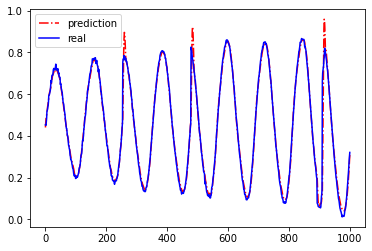

In [1]:
import torch
from torch.utils.data import DataLoader

from config import Config

from utils.dataTools import *
from utils.models import lstm_reg,CNNBiLSTM
from utils.trainer import RNNtrain,RNNevaluate,CNNBiLstmtrain,CNNBiLstm_evaluate

if __name__ == '__main__':
    config = Config()

    print("Data loading...")
    # 序列数据
    dataset = mydataReader("./dataProcessed/testData.csv")

    # 创建X/Y
    # 划分训练集和测试集，70% 作为训练集,10%作为验证集,20%作为测试集
    (train_X ,train_Y ), (val_X,val_Y), (test_X ,test_Y )= dataset.split(lookback=config.lookback,trainSet_ratio=0.7,valSet_ratio=0.1)

    # 创建Pytorch使用的dataset
    trainSet = custom_dataset(train_X,train_Y)
    valSet = custom_dataset(val_X,val_Y)
    testSet = custom_dataset(test_X,test_Y)

    train_loader = DataLoader(trainSet, batch_size = config.batch_size,
                              shuffle=False, pin_memory=True, num_workers=4, drop_last=True)
    val_loader = DataLoader(valSet, batch_size = config.batch_size,
                              shuffle=False, pin_memory=True, num_workers=4, drop_last=False)
    test_loader = DataLoader(testSet, batch_size = config.batch_size,
                            shuffle=False, pin_memory=True, num_workers=4, drop_last=False)

    print("Model loading...")
    model = lstm_reg(1,hidden_size=12,num_layers=1).to(config.device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(),
                                 lr=config.learning_rate, weight_decay=config.weight_decay)

    print("Training...")
    model = RNNtrain(model,
                  trainloader=train_loader,
                  valloader=val_loader,
                  criterion=criterion,
                  optimizer=optimizer,
                  config=config)

    print("Testing...", round(len(testSet)/config.batch_size))
    r2Score,meanSquaredError,meanAbsoluteError = RNNevaluate(model, test_loader, config)


Data loading...


100%|██████████| 19306/19306 [00:00<00:00, 877390.35it/s]

测试集大小为3862
Model loading...


Training...
torch.Size([30, 1, 10])
Epoch: 0 batch: 0 | loss: 0.05971825495362282
Epoch: 0 batch: 10 | loss: 0.4856701195240021
Epoch: 0 batch: 20 | loss: 0.008249416947364807
Epoch: 0 batch: 30 | loss: 0.3555789887905121
Epoch: 0 batch: 40 | loss: 0.033816125243902206
Epoch: 0 batch: 50 | loss: 0.05954332649707794
Epoch: 0 batch: 60 | loss: 0.18440456688404083
Epoch: 0 batch: 70 | loss: 0.010550400242209435
Epoch: 0 batch: 80 | loss: 0.17919707298278809
Epoch: 0 batch: 90 | loss: 0.027140997350215912
Epoch: 0 batch: 100 | loss: 0.035722147673368454
Epoch: 0 batch: 110 | loss: 0.026083121076226234
Epoch: 0 batch: 120 | loss: 0.05620283633470535
Epoch: 0 batch: 130 | loss: 0.036196671426296234
Epoch: 0 batch: 140 | loss: 0.0172728281468153
Epoch: 0 batch: 150 | loss: 0.017467442899942398
Epoch: 0 batch: 160 | loss: 0.03107597678899765
Epoch: 0 batch: 170 | loss: 0.03543759137392044
Epoch: 0 batch: 180 | loss: 0.028504718095064163
Epoch: 0 batch: 190 | loss: 0.02478492632508278
Epoch: 0 

59it [00:01, 60.08it/s]

torch.Size([30, 1, 10])


65it [00:01, 41.81it/s]


Epoch: 0 valLoss: 0.05462353663275835
torch.Size([30, 1, 10])
Epoch: 1 batch: 0 | loss: 0.06985025852918625
Epoch: 1 batch: 10 | loss: 0.05057549849152565
Epoch: 1 batch: 20 | loss: 0.09023846685886383
Epoch: 1 batch: 30 | loss: 0.04646296799182892
Epoch: 1 batch: 40 | loss: 0.024618232622742653
Epoch: 1 batch: 50 | loss: 0.01662636175751686
Epoch: 1 batch: 60 | loss: 0.03171193599700928
Epoch: 1 batch: 70 | loss: 0.06503349542617798
Epoch: 1 batch: 80 | loss: 0.05101297050714493
Epoch: 1 batch: 90 | loss: 0.022390855476260185
Epoch: 1 batch: 100 | loss: 0.02864123322069645
Epoch: 1 batch: 110 | loss: 0.020086269825696945
Epoch: 1 batch: 120 | loss: 0.04254387319087982
Epoch: 1 batch: 130 | loss: 0.023077724501490593
Epoch: 1 batch: 140 | loss: 0.00910029374063015
Epoch: 1 batch: 150 | loss: 0.006117969285696745
Epoch: 1 batch: 160 | loss: 0.01725545898079872
Epoch: 1 batch: 170 | loss: 0.016020899638533592
Epoch: 1 batch: 180 | loss: 0.018942706286907196
Epoch: 1 batch: 190 | loss: 0.

52it [00:01, 55.76it/s]

torch.Size([30, 1, 10])


65it [00:01, 42.71it/s]


Epoch: 1 valLoss: 0.005589459501529317
torch.Size([30, 1, 10])
Epoch: 2 batch: 0 | loss: 0.005612628068774939
Epoch: 2 batch: 10 | loss: 0.003762397915124893
Epoch: 2 batch: 20 | loss: 0.0033720287028700113
Epoch: 2 batch: 30 | loss: 0.003885391168296337
Epoch: 2 batch: 40 | loss: 0.0028479089960455894
Epoch: 2 batch: 50 | loss: 0.004906745627522469
Epoch: 2 batch: 60 | loss: 0.003815971314907074
Epoch: 2 batch: 70 | loss: 0.0039053901564329863
Epoch: 2 batch: 80 | loss: 0.005821527447551489
Epoch: 2 batch: 90 | loss: 0.004515666980296373
Epoch: 2 batch: 100 | loss: 0.00734122097492218
Epoch: 2 batch: 110 | loss: 0.007835695520043373
Epoch: 2 batch: 120 | loss: 0.008613348007202148
Epoch: 2 batch: 130 | loss: 0.011328520253300667
Epoch: 2 batch: 140 | loss: 0.008161832578480244
Epoch: 2 batch: 150 | loss: 0.004069624934345484
Epoch: 2 batch: 160 | loss: 0.0030933627858757973
Epoch: 2 batch: 170 | loss: 0.001347533892840147
Epoch: 2 batch: 180 | loss: 0.003128691576421261
Epoch: 2 batch

20it [00:01, 20.92it/s]

torch.Size([30, 1, 10])


65it [00:01, 40.95it/s]


Epoch: 2 valLoss: 0.004798692912958878
torch.Size([30, 1, 10])
Epoch: 3 batch: 0 | loss: 0.003474054392427206
Epoch: 3 batch: 10 | loss: 0.004334541503340006
Epoch: 3 batch: 20 | loss: 0.001147399889305234
Epoch: 3 batch: 30 | loss: 0.0020397892221808434
Epoch: 3 batch: 40 | loss: 0.002645681379362941
Epoch: 3 batch: 50 | loss: 0.0034270549658685923
Epoch: 3 batch: 60 | loss: 0.0033305869437754154
Epoch: 3 batch: 70 | loss: 0.0017282351618632674
Epoch: 3 batch: 80 | loss: 0.0030031136702746153
Epoch: 3 batch: 90 | loss: 0.009396175853908062
Epoch: 3 batch: 100 | loss: 0.006603499408811331
Epoch: 3 batch: 110 | loss: 0.0046264841221272945
Epoch: 3 batch: 120 | loss: 0.009049487300217152
Epoch: 3 batch: 130 | loss: 0.008086281828582287
Epoch: 3 batch: 140 | loss: 0.0057987309992313385
Epoch: 3 batch: 150 | loss: 0.004054517950862646
Epoch: 3 batch: 160 | loss: 0.003205937333405018
Epoch: 3 batch: 170 | loss: 0.0012185010127723217
Epoch: 3 batch: 180 | loss: 0.0010741377482190728
Epoch: 3

18it [00:01, 19.43it/s]

torch.Size([30, 1, 10])


65it [00:01, 42.06it/s]


Epoch: 3 valLoss: 0.004147462272862317
torch.Size([30, 1, 10])
Epoch: 4 batch: 0 | loss: 0.0035445154644548893
Epoch: 4 batch: 10 | loss: 0.0039694360457360744
Epoch: 4 batch: 20 | loss: 0.001021208125166595
Epoch: 4 batch: 30 | loss: 0.0037929394748061895
Epoch: 4 batch: 40 | loss: 0.0016189048765227199
Epoch: 4 batch: 50 | loss: 0.0020082893315702677
Epoch: 4 batch: 60 | loss: 0.0016928918194025755
Epoch: 4 batch: 70 | loss: 0.0012024500174447894
Epoch: 4 batch: 80 | loss: 0.0024925628677010536
Epoch: 4 batch: 90 | loss: 0.004702792968600988
Epoch: 4 batch: 100 | loss: 0.005054904613643885
Epoch: 4 batch: 110 | loss: 0.005135618150234222
Epoch: 4 batch: 120 | loss: 0.007451955229043961
Epoch: 4 batch: 130 | loss: 0.007466230075806379
Epoch: 4 batch: 140 | loss: 0.0050032371655106544
Epoch: 4 batch: 150 | loss: 0.003374154679477215
Epoch: 4 batch: 160 | loss: 0.0020187152549624443
Epoch: 4 batch: 170 | loss: 0.0021452424116432667
Epoch: 4 batch: 180 | loss: 0.001561543671414256
Epoch:

35it [00:01, 37.31it/s]

torch.Size([30, 1, 10])


65it [00:01, 42.26it/s]


Epoch: 4 valLoss: 0.0035569687829789674
torch.Size([30, 1, 10])
Epoch: 5 batch: 0 | loss: 0.002143176505342126
Epoch: 5 batch: 10 | loss: 0.004529849626123905
Epoch: 5 batch: 20 | loss: 0.0009057497372850776
Epoch: 5 batch: 30 | loss: 0.002456196118146181
Epoch: 5 batch: 40 | loss: 0.0011230215895920992
Epoch: 5 batch: 50 | loss: 0.0024558769073337317
Epoch: 5 batch: 60 | loss: 0.002258153399452567
Epoch: 5 batch: 70 | loss: 0.0012012735242024064
Epoch: 5 batch: 80 | loss: 0.004354933276772499
Epoch: 5 batch: 90 | loss: 0.003921739757061005
Epoch: 5 batch: 100 | loss: 0.003365499898791313
Epoch: 5 batch: 110 | loss: 0.005280311219394207
Epoch: 5 batch: 120 | loss: 0.0059799375012516975
Epoch: 5 batch: 130 | loss: 0.0045518637634813786
Epoch: 5 batch: 140 | loss: 0.004426212515681982
Epoch: 5 batch: 150 | loss: 0.004107525572180748
Epoch: 5 batch: 160 | loss: 0.0018210209673270583
Epoch: 5 batch: 170 | loss: 0.0019151833839714527
Epoch: 5 batch: 180 | loss: 0.0009068195358850062
Epoch: 

19it [00:01, 20.48it/s]

torch.Size([30, 1, 10])


65it [00:01, 41.95it/s]


Epoch: 5 valLoss: 0.0032284611745050126
torch.Size([30, 1, 10])
Epoch: 6 batch: 0 | loss: 0.0023430967703461647
Epoch: 6 batch: 10 | loss: 0.004447336308658123
Epoch: 6 batch: 20 | loss: 0.0004434212460182607
Epoch: 6 batch: 30 | loss: 0.002636650111526251
Epoch: 6 batch: 40 | loss: 0.002039722865447402
Epoch: 6 batch: 50 | loss: 0.002818427514284849
Epoch: 6 batch: 60 | loss: 0.002263092203065753
Epoch: 6 batch: 70 | loss: 0.0008557742112316191
Epoch: 6 batch: 80 | loss: 0.003202853025868535
Epoch: 6 batch: 90 | loss: 0.004277425352483988
Epoch: 6 batch: 100 | loss: 0.005248683970421553
Epoch: 6 batch: 110 | loss: 0.0025202136021107435
Epoch: 6 batch: 120 | loss: 0.004344078712165356
Epoch: 6 batch: 130 | loss: 0.0055364384315907955
Epoch: 6 batch: 140 | loss: 0.004042692482471466
Epoch: 6 batch: 150 | loss: 0.0018723987741395831
Epoch: 6 batch: 160 | loss: 0.0014016226632520556
Epoch: 6 batch: 170 | loss: 0.0014516761293634772
Epoch: 6 batch: 180 | loss: 0.0007014713482931256
Epoch: 

29it [00:01, 30.98it/s]

torch.Size([30, 1, 10])


65it [00:01, 41.52it/s]


Epoch: 6 valLoss: 0.0025694858544625227
torch.Size([30, 1, 10])
Epoch: 7 batch: 0 | loss: 0.002099247183650732
Epoch: 7 batch: 10 | loss: 0.0025225405115634203
Epoch: 7 batch: 20 | loss: 0.0006324236746877432
Epoch: 7 batch: 30 | loss: 0.0012419831473380327
Epoch: 7 batch: 40 | loss: 0.0006441111327148974
Epoch: 7 batch: 50 | loss: 0.0014327061362564564
Epoch: 7 batch: 60 | loss: 0.0022330922074615955
Epoch: 7 batch: 70 | loss: 0.0014265525387600064
Epoch: 7 batch: 80 | loss: 0.002152560045942664
Epoch: 7 batch: 90 | loss: 0.001799252931959927
Epoch: 7 batch: 100 | loss: 0.003135611303150654
Epoch: 7 batch: 110 | loss: 0.002317950362339616
Epoch: 7 batch: 120 | loss: 0.004701418802142143
Epoch: 7 batch: 130 | loss: 0.004644079599529505
Epoch: 7 batch: 140 | loss: 0.003434962360188365
Epoch: 7 batch: 150 | loss: 0.0016775241820141673
Epoch: 7 batch: 160 | loss: 0.000650668574962765
Epoch: 7 batch: 170 | loss: 0.0018492686795070767
Epoch: 7 batch: 180 | loss: 0.0005905303405597806
Epoch:

52it [00:01, 55.05it/s]

torch.Size([30, 1, 10])


65it [00:01, 42.22it/s]


Epoch: 7 valLoss: 0.0022444521258303944
torch.Size([30, 1, 10])
Epoch: 8 batch: 0 | loss: 0.0014962374698370695
Epoch: 8 batch: 10 | loss: 0.0017126211896538734
Epoch: 8 batch: 20 | loss: 0.0005490572657436132
Epoch: 8 batch: 30 | loss: 0.0011892362963408232
Epoch: 8 batch: 40 | loss: 0.000783283612690866
Epoch: 8 batch: 50 | loss: 0.0014134468510746956
Epoch: 8 batch: 60 | loss: 0.0011807340197265148
Epoch: 8 batch: 70 | loss: 0.0010065403766930103
Epoch: 8 batch: 80 | loss: 0.0015412040520459414
Epoch: 8 batch: 90 | loss: 0.0023038771469146013
Epoch: 8 batch: 100 | loss: 0.0028829816728830338
Epoch: 8 batch: 110 | loss: 0.0020037787035107613
Epoch: 8 batch: 120 | loss: 0.004129144828766584
Epoch: 8 batch: 130 | loss: 0.0038724986370652914
Epoch: 8 batch: 140 | loss: 0.002681838581338525
Epoch: 8 batch: 150 | loss: 0.0018119694432243705
Epoch: 8 batch: 160 | loss: 0.0003801541170105338
Epoch: 8 batch: 170 | loss: 0.0013932468136772513
Epoch: 8 batch: 180 | loss: 0.0008943987777456641


18it [00:01, 20.48it/s]

torch.Size([30, 1, 10])


65it [00:01, 43.52it/s]


Epoch: 8 valLoss: 0.0017704731559879607
torch.Size([30, 1, 10])
Epoch: 9 batch: 0 | loss: 0.001244263956323266
Epoch: 9 batch: 10 | loss: 0.0016220510005950928
Epoch: 9 batch: 20 | loss: 0.000718663795851171
Epoch: 9 batch: 30 | loss: 0.0012411349453032017
Epoch: 9 batch: 40 | loss: 0.0005459547974169254
Epoch: 9 batch: 50 | loss: 0.0012332176556810737
Epoch: 9 batch: 60 | loss: 0.0013736860128119588
Epoch: 9 batch: 70 | loss: 0.0007902489742264152
Epoch: 9 batch: 80 | loss: 0.001061705406755209
Epoch: 9 batch: 90 | loss: 0.0017187735065817833
Epoch: 9 batch: 100 | loss: 0.0027670208364725113
Epoch: 9 batch: 110 | loss: 0.0008697782759554684
Epoch: 9 batch: 120 | loss: 0.002443518955260515
Epoch: 9 batch: 130 | loss: 0.004219799768179655
Epoch: 9 batch: 140 | loss: 0.0014890447491779923
Epoch: 9 batch: 150 | loss: 0.0007518419879488647
Epoch: 9 batch: 160 | loss: 0.0004005469672847539
Epoch: 9 batch: 170 | loss: 0.000871283991727978
Epoch: 9 batch: 180 | loss: 0.0006003673188388348
Epo

35it [00:01, 36.67it/s]

torch.Size([30, 1, 10])


65it [00:01, 41.61it/s]


Epoch: 9 valLoss: 0.0014839552574879115
Testing... 129


46it [00:01, 47.14it/s]

torch.Size([30, 1, 10])


129it [00:01, 76.85it/s] 


r2Score:  0.9658994287212367
meanSquaredError:  0.001764190125954151
RMSE:  0.04200226334323129
meanAbsoluteError:  0.02831919923794163


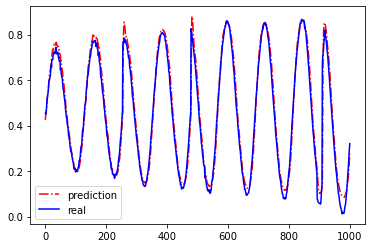

In [1]:
import torch
from torch.utils.data import DataLoader

from config import Config

from utils.dataTools import *
from utils.models import lstm_reg,CNNBiLSTM
from utils.trainer import CNNBiLstm_evaluate,CNNBiLstmtrain

if __name__ == '__main__':
    config = Config()

    print("Data loading...")
    # 序列数据
    dataset = mydataReader("./dataProcessed/testData.csv")

    # 创建X/Y
    # 划分训练集和测试集，70% 作为训练集,10%作为验证集,20%作为测试集
    (train_X ,train_Y ), (val_X,val_Y), (test_X ,test_Y )= dataset.split(lookback=config.lookback,trainSet_ratio=0.7,valSet_ratio=0.1)

    # 创建Pytorch使用的dataset
    trainSet = custom_dataset(train_X,train_Y)
    valSet = custom_dataset(val_X,val_Y)
    testSet = custom_dataset(test_X,test_Y)

    train_loader = DataLoader(trainSet, batch_size = config.batch_size,
                              shuffle=False, pin_memory=True, num_workers=4, drop_last=True)
    val_loader = DataLoader(valSet, batch_size = config.batch_size,
                              shuffle=False, pin_memory=True, num_workers=4, drop_last=False)
    test_loader = DataLoader(testSet, batch_size = config.batch_size,
                            shuffle=False, pin_memory=True, num_workers=4, drop_last=False)


    print("Model loading...")
    model = CNNBiLSTM(hidden_size=12,num_layers=2).to(config.device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(),
                                 lr=config.learning_rate, weight_decay=config.weight_decay)

    print("Training...")
    model = CNNBiLstmtrain(model,
                  trainloader=train_loader,
                  valloader=val_loader,
                  criterion=criterion,
                  optimizer=optimizer,
                  config=config)

    print("Testing...", round(len(testSet)/config.batch_size))
    CNNBiLstm_evaluate(model, test_loader, config)


In [2]:
np.sqrt(0.00963681919891161)

0.09816730208634447

In [4]:
train_Y.shape

(13514, 1)

E:\Anaconda3\envs\mytorch\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[22:27:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "randam_state" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.0006948821
6.888661e-05
0.986568410346917
[0.4532925  0.45307374 0.450886   ... 0.3329687  0.31874862 0.31809232]
[0.44522548 0.46735933 0.4685528  ... 0.34392446 0.31983602 0.3050364 ]


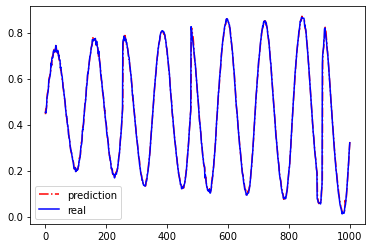

In [2]:
# 加载xgboost模型
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import xgboost as xgb

# 定义模型
model = xgb.XGBRegressor(max_depth = 6,learning_rate = 0.05,n_estimators = 100,randam_state=42)

# 训练
model.fit(train_X.squeeze(),train_Y.squeeze())
test_predict=model.predict(test_X.squeeze())
train_predict = model.predict(train_X.squeeze())

# MSE
msetest=mean_squared_error(test_Y.squeeze(),test_predict)
msetrain=mean_squared_error(train_Y.squeeze(),train_predict)
print(msetest)
print(msetrain)

# R2-score
r2Test = r2_score(test_Y.squeeze(),test_predict)
print(r2Test)

# 画出实际结果和预测的结果
import matplotlib.pyplot as plt
y = test_Y.squeeze()
y_pre = test_predict
print(y)
print(y_pre)
plt.plot(range(len(y[:1000])),y_pre[:1000],color = 'red',linewidth = 1.5,linestyle = '-.',label='prediction')
plt.plot(range(len(y[:1000])),y[:1000],color = 'blue',linewidth = 1.5,linestyle = '-', label='real')
plt.legend(loc='best')